### __NLP Various Models Comparsion (columntransformer & pipeline & pickle)__

In [1]:
%%time
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import pickle
%matplotlib inline

Wall time: 1.39 s


In [2]:
path = r"D:\LIUZHICHENG\Udemy\Natural Language Processing\Jose\Section 5\smsspamcollection.tsv"
path

'D:\\LIUZHICHENG\\Udemy\\Natural Language Processing\\Jose\\Section 5\\smsspamcollection.tsv'

In [3]:
df = pd.read_csv(filepath_or_buffer=path, sep="\t")
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


__EDA__

In [4]:
df.isnull().mean()

label      0.0
message    0.0
length     0.0
punct      0.0
dtype: float64

In [5]:
len(df)

5572

In [6]:
df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

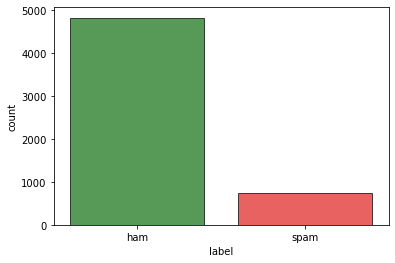

In [7]:
sns.countplot(data=df, x="label", alpha=0.7, palette={"ham": "green", "spam": "red"}, edgecolor="black");

__Text Preprocessing__

In [8]:
%%time

import string
import re
import nltk
from nltk.corpus import stopwords

def remove_punctuation(input_text):

    """ Remove punctuations like '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' """

    #print("in remove_punctuation\n",input_text)
    # Make translation table
    input_text = str(input_text) # avoid thedange of being a series object
    punct = string.punctuation
    trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
    return input_text.translate(trantab).encode('ascii', 'ignore').decode('utf8') # -> Final kick to clean up :)


def remove_digits(input_text):

    """ Remove numerical digits ranging from 0-9 """
    #print("in remove_digits\n",input_text)
    return re.sub('\d+', '', input_text)

   
def to_lower(input_text):

    """ String handling, returns the lowercased strings from the given string """
    #print("in to_lower\n",input_text)
    return input_text.lower()


def remove_stopwords(input_text):

    """ Remove the low-level information from our text in order to give more focus to the important information """
   #print("in remove_stopwords\n",input_text)
    stopwords_list = stopwords.words('english')
    newStopWords = ['citi']
    stopwords_list.extend(newStopWords)

    # Some words which might indicate a certain sentiment are kept via a whitelist
    #whitelist = ["n't", "not", "no"]
    whitelist = ["n't"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 2]         
    return " ".join(clean_words) # list -> string

 
def expandShortsForms(input_text):
    #print("in expandShortsForms\n",input_text)
    return input_text.replace("can't", "can not").replace("won't", "will not")


def lemmatize(input_text):

    """ Return the base or dictionary form of a word, lemma """
    #print("in lemmatize\n",input_text)
    outtext= ""
    # Lemmatize
    from nltk.stem import WordNetLemmatizer
    from nltk import pos_tag, word_tokenize, wordnet
    from nltk.corpus.reader.wordnet import WordNetError
    lemmatizer = WordNetLemmatizer()

    input_text = input_text.split()
    for word in input_text:
        # Get the single character pos constant from pos_tag like this:
        pos_label = (pos_tag(word_tokenize(word))[0][1][0]).lower()

        # pos_refs = {'n': ['NN', 'NNS', 'NNP', 'NNPS'],
        #            'v': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
        #            'r': ['RB', 'RBR', 'RBS'],
        #            'a': ['JJ', 'JJR', 'JJS']}

        if pos_label == 'j': pos_label = 'a'    # 'j' <--> 'a' reassignment

        if pos_label in ['r']:  # For adverbs it's a bit different
            try:
                if len(wordnet.wordnet.synset(word+'.r.1').lemmas()[0].pertainyms()) > 0:
                    outtext = outtext + ' ' +  (wordnet.wordnet.synset(word+'.r.1').lemmas()[0].pertainyms()[0].name())
            except WordNetError:
                pass
            outtext = outtext + ' ' + word # To keep the word in the list
        elif pos_label in ['a', 's', 'v']: # For adjectives and verbs
            outtext = outtext +' ' + (lemmatizer.lemmatize(word, pos=pos_label))
        else:   # For nouns and everything else as it is the default kwarg
            outtext = outtext +' ' + (lemmatizer.lemmatize(word))
       
    return outtext

       
def execute_funcs(input_text, *args):
    funcs = list(args)
    for func in funcs:
        input_text = func(input_text)
    return input_text


def apply_funcs(input_text):
    clean_X = execute_funcs(input_text, to_lower, remove_punctuation, remove_digits, 
                            remove_stopwords, 
                            expandShortsForms, 
#                             lemmatize
                           )
    return clean_X

Wall time: 403 ms


__Model Training__

In [9]:
%%time

import warnings
warnings.filterwarnings('ignore')

df["clean_message"] = df["message"].apply(func=apply_funcs)

y = df["label"]
X = df.drop(labels="label", axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y_train = enc.fit_transform(y=y_train)
y_test = enc.transform(y=y_test)


from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler

# This is a shorthand for the ColumnTransformer constructor; it does not require, and does not permit, naming the 
# transformers.
ct = make_column_transformer(
    (TfidfVectorizer(), ("clean_message")),
    (StandardScaler(), (["length", "punct"])),
    n_jobs=-1)

from sklearn.pipeline import make_pipeline

# CatBoostClassifier
# from catboost import CatBoostClassifier
# clf = make_pipeline(ct, CatBoostClassifier())

# LGBMClassifier
# from lightgbm import LGBMClassifier
# clf = make_pipeline(ct, LGBMClassifier())

# XGBClassifier
# from xgboost import XGBClassifier
# clf = make_pipeline(ct, XGBClassifier())

# SGDClassifier
from sklearn.linear_model import SGDClassifier
clf = make_pipeline(ct, SGDClassifier()) 

# LogisticRegression
# from sklearn.linear_model import LogisticRegression
# clf = make_pipeline(ct, LogisticRegression()) 

# SVC linear
# from sklearn.svm import SVC
# clf = make_pipeline(ct, SVC(kernel='linear', random_state = 0)) 

# SVC rbf, Radial Basis Function
# from sklearn.svm import SVC
# clf = make_pipeline(ct, SVC(kernel='rbf', random_state = 0))

# KNeighborsClassifier
# from sklearn.neighbors import KNeighborsClassifier
# clf = make_pipeline(ct, KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)) 

# DecisionTreeClassifier
# from sklearn.tree import DecisionTreeClassifier
# clf = make_pipeline(ct, DecisionTreeClassifier(criterion='entropy', random_state=0)) 

clf.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       966
           1       0.90      0.89      0.90       149

    accuracy                           0.97      1115
   macro avg       0.94      0.94      0.94      1115
weighted avg       0.97      0.97      0.97      1115

0.9730941704035875
[[952  14]
 [ 16 133]]
Wall time: 3.96 s


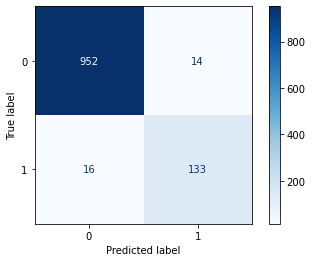

In [10]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(estimator=clf, X=X_test, y_true=y_test, cmap="Blues");

In [11]:
from sklearn import set_config

set_config(display="diagram")

clf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'clean_message'),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['length', 'punct'])])),
                ('sgdclassifier', SGDClassifier())])

__save modle__

In [12]:
import pickle

# Save trained model to file
pickle.dump(obj=clf, file=open("nlp_movie_clf.pkl", "wb"))

In [13]:
# load model 
loaded_clf = pickle.load(file=open("nlp_movie_clf.pkl", "rb"))

__predict__

In [14]:
tmp_df = pd.DataFrame(data={"clean_message": "I don't know", "length": 12, "punct": 2}, index=[0])
tmp_df

,clean_message,length,punct
0,I don't know,12,2


In [15]:
loaded_clf.predict(tmp_df)

array([0])

__itertuples()__

In [16]:
df.head()

,label,message,length,punct,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,jurong point crazy available bugis great world...
1,ham,Ok lar... Joking wif u oni...,29,6,lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,free entry wkly comp win cup final tkts may te...
3,ham,U dun say so early hor... U c already then say...,49,6,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,nah think goes usf lives around though


In [17]:
for index, col1_value, col2_value, col3_value, col4_value, col5_value in df.itertuples():
    print(index, col1_value, col2_value, col3_value, col4_value, col5_value)
    break

0 ham Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... 111 9 jurong point crazy available bugis great world buffet cine got amore wat
